# EMG Signal Processing Pipeline

This notebook demonstrates the step-by-step processing pipeline for EMG signals, mirroring the real-time firmware implementation.

**Pipeline Steps:**
1. **Raw Data Loading**: Ingesting raw sensor data.
2. **Filtering**: Bandpass (20-450Hz) and Notch (50Hz) to remove noise.
3. **Rectification**: Full-wave rectification to estimate signal power.
4. **Feature Extraction**: Computing Mean Absolute Value (MAV) and Waveform Length (WL).

In [37]:
import sys
import numpy as np
import matplotlib.pyplot as plt

# Add src to path for imports
sys.path.insert(0, '../')

from data_loader import Enabl3sDataLoader
from preprocessing import EMGPreprocessor

# Setup plotting
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

## 1. Data Loading

We load a single circuit from patient `AB156` to visualize the signals.

In [38]:
DATA_ROOT = "../../data"
SUBJECT_ID = "AB156"
CIRCUIT_ID = 1
CHANNELS = ['TA', 'MG', 'RF']

# Initialize Loader
loader = Enabl3sDataLoader(DATA_ROOT, SUBJECT_ID)

# Load specific circuit
df_raw = loader.load_circuit(CIRCUIT_ID, CHANNELS)

raw_data = df_raw.values
time_axis = np.arange(len(df_raw)) / 1000.0

print(f"Loaded {raw_data.shape[0]} samples for {SUBJECT_ID} - Circuit {CIRCUIT_ID}")
df_raw.head()

Loaded 36870 samples for AB156 - Circuit 1


,TA,MG,RF
0,-0.110857,-0.078660,-0.069352
1,-0.094835,-0.069810,-0.062943
2,-0.083238,-0.055314,-0.055772
3,-0.076219,-0.051194,-0.049821
4,-0.071336,-0.048295,-0.049668


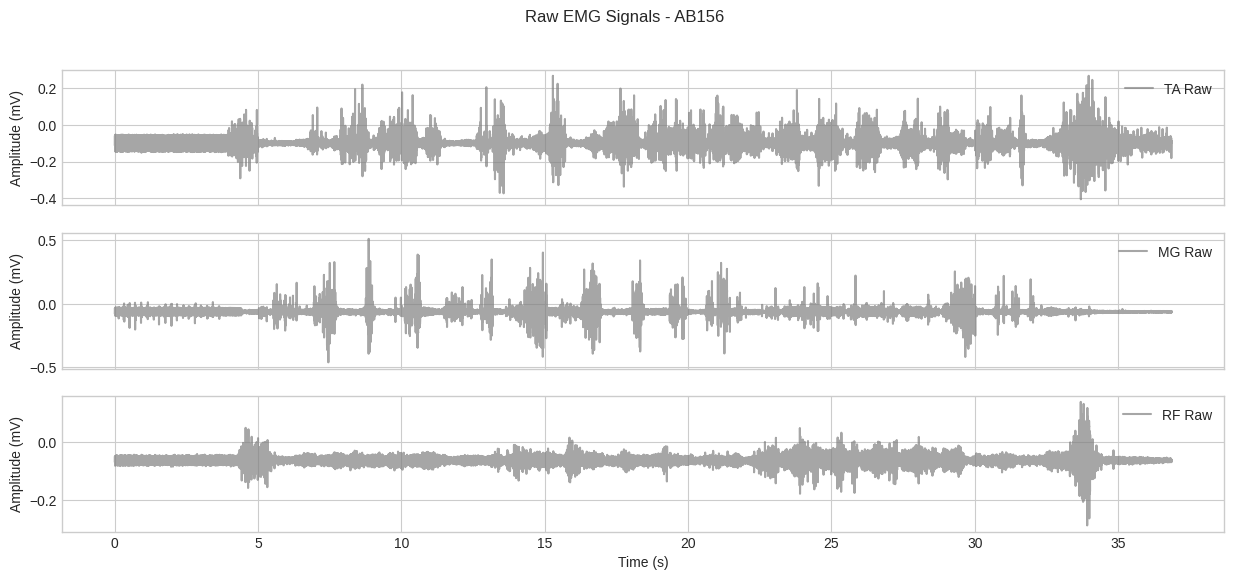

In [39]:
# Plot Raw Signals
fig, axes = plt.subplots(len(CHANNELS), 1, sharex=True)
fig.suptitle(f"Raw EMG Signals - {SUBJECT_ID}")

for i, ch in enumerate(CHANNELS):
    axes[i].plot(time_axis, raw_data[:, i], label=f'{ch} Raw', color='gray', alpha=0.7)
    axes[i].set_ylabel("Amplitude (mV)")
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel("Time (s)")
plt.show()

## 2. Filtering

We apply two filters to clean the signal:
1. **Bandpass Filter (20-450 Hz)**: Removes low-frequency motion artifacts and high-frequency noise outside the EMG spectrum.
2. **Notch Filter (50 Hz)**: Removes power line interference.

> **Note**: The filters are *causal* (using `lfilter`/`sosfilt` instead of `filtfilt`) to simulate real-time processing delays.

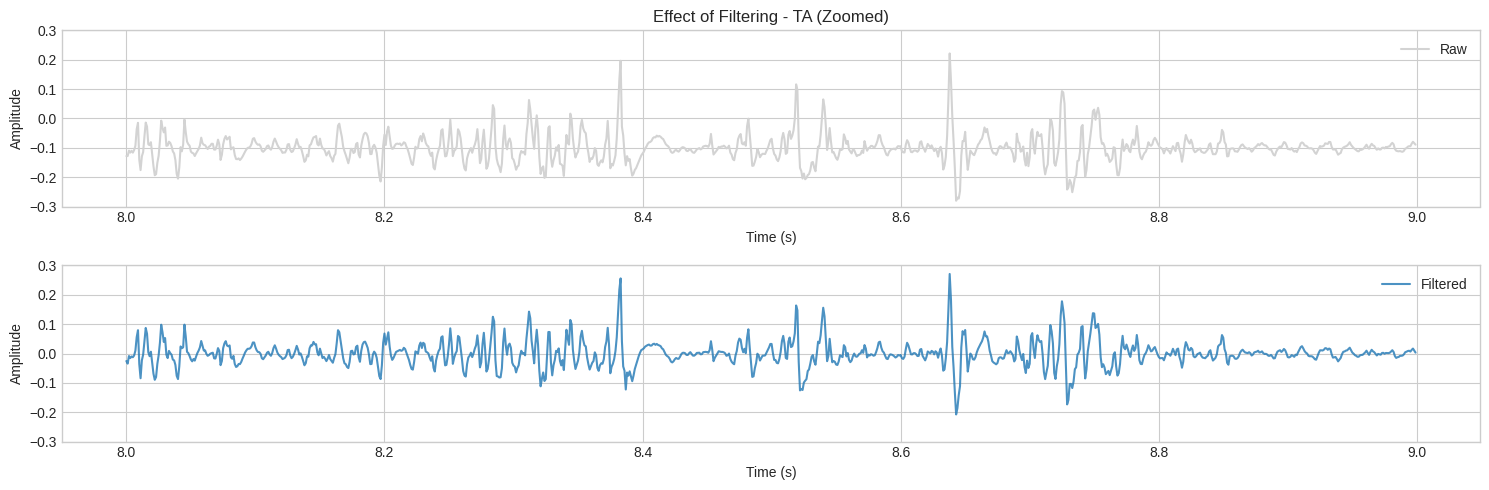

In [40]:
preprocessor = EMGPreprocessor(fs=1000.0)

# Apply Filter
filtered_data = preprocessor.apply_filter(raw_data)

# Visualize Filter Effect (Zoomed in)
# Choosing a window where there might be activity to see signal preservation, or rest to see noise removal
zoom_slice = slice(8000, 9000)

fig, ax = plt.subplots(2, 1, figsize=(15, 5))
ax[0].set_title(f"Effect of Filtering - {CHANNELS[0]} (Zoomed)")
ax[0].plot(time_axis[zoom_slice], raw_data[zoom_slice, 0], label='Raw', color='lightgray')
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Amplitude")
ax[0].set_ylim([-0.3, 0.3])
ax[0].legend()

ax[1].plot(time_axis[zoom_slice], filtered_data[zoom_slice, 0], label='Filtered', color='tab:blue', alpha=0.8)
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Amplitude")
ax[1].set_ylim([-0.3, 0.3])
ax[1].legend()

plt.tight_layout()
plt.show()

## 3. Rectification

EMG signals are oscillatory with a zero mean. To estimate the muscle activation intensity, we perform full-wave rectification (absolute value).

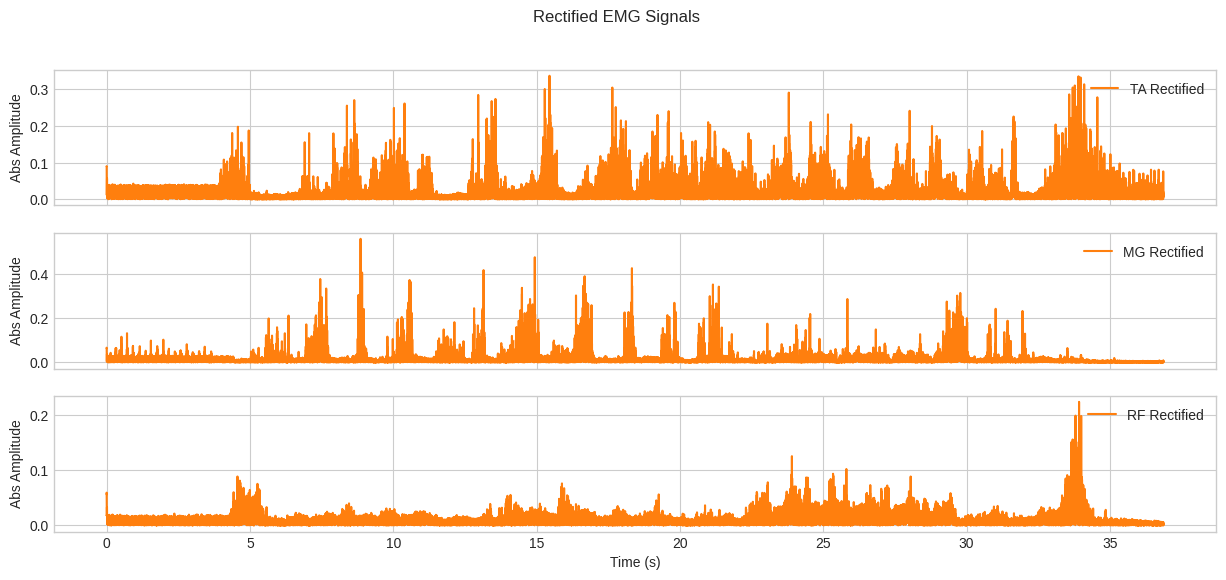

In [41]:
rectified_data = preprocessor.rectify(filtered_data)

# Plot Rectified Signal
fig, axes = plt.subplots(len(CHANNELS), 1, sharex=True)
fig.suptitle("Rectified EMG Signals")

for i, ch in enumerate(CHANNELS):
    axes[i].plot(time_axis, rectified_data[:, i], label=f'{ch} Rectified', color='tab:orange')
    axes[i].set_ylabel("Abs Amplitude")
    axes[i].legend(loc='upper right')

axes[-1].set_xlabel("Time (s)")
plt.show()

## 4. Feature Extraction

We extract time-domain features using a sliding window approach.

### Features:
1. **MAV (Mean Absolute Value)**: Represents the average intensity of the muscle contraction.
2. **WL (Waveform Length)**: Measures the complexity/cumulative length of the waveform, related to signal amplitude, frequency, and duration.

**Window Parameters:**
- Window Size: 100ms
- Step Size: 100ms (Non-overlapping)

In [42]:
WINDOW_MS = 100
STEP_MS = 100

# Compute Features
# Note: The preprocessor handles the windowing internally
features = preprocessor.compute_features(rectified_data, window_size_ms=WINDOW_MS, step_size_ms=STEP_MS)

print(f"Feature Matrix Shape: {features.shape}")
# Features are interleaved for each channel: [Ch1_MAV, Ch1_WL, Ch2_MAV, Ch2_WL, ...]

Feature Matrix Shape: (368, 6)


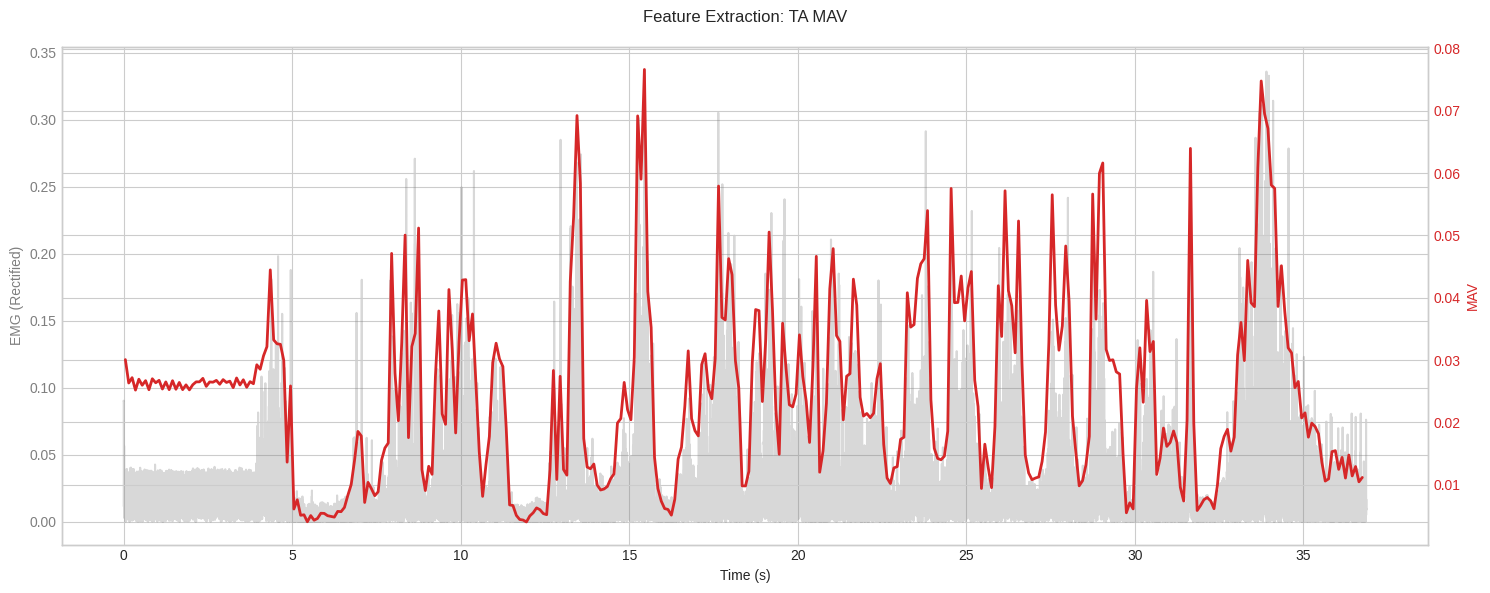

In [43]:
# Visualization of Features for one channel (e.g., TA)
ch_idx = 0  # TA
mav_idx = ch_idx * 2
wl_idx = ch_idx * 2 + 1

n_windows = features.shape[0]
# Calculate timepoints for features (centered in window)
feature_time_axis = np.arange(n_windows) * (STEP_MS / 1000.0) + (WINDOW_MS / 1000.0) / 2

fig, ax1 = plt.subplots(figsize=(15, 6))

color = 'tab:gray'
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('EMG (Rectified)', color=color)
ax1.plot(time_axis, rectified_data[:, ch_idx], color=color, alpha=0.3, label='Rectified Signal')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('MAV', color=color)
ax2.plot(feature_time_axis, features[:, mav_idx], color=color, linewidth=2, label='MAV Feature')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle(f"Feature Extraction: {CHANNELS[ch_idx]} MAV")
fig.tight_layout()
plt.show()